<a href="https://colab.research.google.com/github/federicoweill/pycardano-tutorial/blob/main/pycardano_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python Jupyter Notebook for Cardano on Demeter

In [1]:
import matplotlib.pyplot as plt

In [2]:
"""Single-script demo to show how to access on on-chain datum."""
# pylint: disable=W0718, C0206

import json
import logging
import sys
from collections import OrderedDict
from dataclasses import dataclass
from datetime import datetime, timezone
from typing import Final

import cbor2
import numpy
import pycardano
from pycardano import Address, Network, OgmiosChainContext, UTxO

OGMIOS_URL: Final[str] = "ws://ogmios.preprod.orcfax.io:1337"

# smart contract
ADA_USD_ORACLE_ADDR: Final[
    str
] = "addr_test1wrtcecfy7np3sduzn99ffuv8qx2sa8v977l0xql8ca7lgkgmktuc0"

auth_addr = Address.from_primitive(
    "addr_test1vrc7lrdcsz08vxuj4278aeyn4g82salal76l54gr6rw4ync86tfse"
)

# policy ID for the Auth tokens
AUTH_POLICY: Final[str] = "104d51dd927761bf5d50d32e1ede4b2cff477d475fe32f4f780a4b21"

network = Network.TESTNET
context = OgmiosChainContext(ws_url=OGMIOS_URL, network=network)

logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)-15s %(levelname)s :: %(filename)s:%(lineno)s:%(funcName)s() :: %(message)s",
    datefmt="%Y-%m-%dT%H:%M:%SZ",
    level="INFO",
)


def _decode_number(value_pair: list):
    """Decode a number value."""
    significand = numpy.uint64(value_pair[0]).astype(numpy.int64)
    base10_component = numpy.uint64(value_pair[1]).astype(numpy.int64)
    value = significand * 10 ** numpy.float_(base10_component)
    return value


def timestamp_to_human(timestamp):
    return datetime.utcfromtimestamp(int(timestamp) / 1000).strftime(
        "%Y-%m-%dT%H:%M:%SZ"
    )


def decode_utxo(utxo: pycardano.transaction.UTxO):
    """Split a UTxO into the components that we need to process and
    initially return the Orcfax Datum."""
    oracle_datum = cbor2.loads(utxo.output.datum.cbor)
    timestamp = oracle_datum.value[2].value[0]
    timestamp_human = timestamp_to_human(timestamp)
    logger.info("oracle datum timestamp: %s (%s)", timestamp_human, timestamp)
    labels = oracle_datum.value[0][b"name"].decode().split("|", 1)
    ada_usd = oracle_datum.value[0][b"value"][0].value
    pretty_log_value(ada_usd, labels[0])
    return (timestamp, _decode_number(ada_usd))


def pretty_log_value(value_pair: cbor2.CBORTag, label: str):
    """Return pretty logging information about a value pair."""
    value = _decode_number(value_pair)
    logger.info("%s: %s", label, value)


def validate_utxo(utxo: UTxO):
    """check if the token included in the utxo is the correct one."""
    valid = False
    for item in utxo.output.amount.multi_asset:
        if str(item) == AUTH_POLICY:
            valid = True
            for asset in utxo.output.amount.multi_asset[item]:
                amount = utxo.output.amount.multi_asset[item][asset]
                logger.info("found %d %s", amount, str(asset))
    return valid


def get_utxos(oracle_addr: str):
    """return the Orcfax UTxOs."""
    oracle_utxos = context.utxos(oracle_addr)
    utxos = []
    logger.info("inspecting '%s' UTxOs", len(oracle_utxos))
    for utxo in oracle_utxos:
        if not utxo.output.script and utxo.output.datum and validate_utxo(utxo):
            utxos.append(utxo)
    return utxos


def read_datum():
    """Get the timestamps and prices from all validated Orcfax UTxOs."""
    logger.info("entering this script... ")
    logger.info("oracle smart contract: %s", ADA_USD_ORACLE_ADDR)
    utxos = get_utxos(ADA_USD_ORACLE_ADDR)
    times_prices = []
    if not utxos:
        logger.info("no oracle data found")
        sys.exit(0)
    for utxo in utxos:
        (timestamp, ada_usd) = decode_utxo(utxo)
        times_prices.append((timestamp, ada_usd))
    return times_prices

In [3]:
times_prices = read_datum()
times_prices.sort(key=lambda tp: tp[0])

2024-01-02T01:53:59Z INFO :: 1906248053.py:101:read_datum() :: entering this script... 
2024-01-02T01:53:59Z INFO :: 1906248053.py:102:read_datum() :: oracle smart contract: addr_test1wrtcecfy7np3sduzn99ffuv8qx2sa8v977l0xql8ca7lgkgmktuc0
2024-01-02T01:54:02Z INFO :: 1906248053.py:92:get_utxos() :: inspecting '870' UTxOs
2024-01-02T01:54:02Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 7741b5c48697c78363e89d48f22760b9d578bb797097211e424bb955e33f679c
2024-01-02T01:54:02Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 6e119fba0a07dd329c384bc82d35538ad30b051e96f1b0feaa79d68ddd548a78
2024-01-02T01:54:02Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 ad445385b1696e5b76e039e1fae22e9a6508837698e4d7a3617bca67885a5890
2024-01-02T01:54:02Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 4f7eb0b987aec99952be0ef9b21066ab76bc554eea9a3fd2bc31852eebfa58c2
2024-01-02T01:54:02Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 304d7f07fbc7b6d0d81bf0869c081c20a8b8cef44bea1ba6430c0

2024-01-01T08:02:13Z,0.597667
2024-01-01T09:02:16Z,0.5991000000000001
2024-01-01T10:02:19Z,0.599339
2024-01-01T11:02:22Z,0.6012000000000001
2024-01-01T12:02:24Z,0.6024737466
2024-01-01T13:02:27Z,0.6030139999999999
2024-01-01T14:02:00Z,0.6057
2024-01-01T15:02:03Z,0.6037323672
2024-01-01T16:02:06Z,0.601538
2024-01-01T17:02:09Z,0.606
2024-01-01T18:02:11Z,0.6030733013
2024-01-01T19:02:14Z,0.6059
2024-01-01T19:30:38Z,0.612
2024-01-01T20:02:17Z,0.610001
2024-01-01T20:47:54Z,0.6163428474
2024-01-01T21:02:20Z,0.61875
2024-01-01T22:02:23Z,0.61885
2024-01-01T23:02:26Z,0.617059
2024-01-02T00:02:28Z,0.6192000000000001
2024-01-02T01:02:01Z,0.6231500000000001
2024-01-02T01:25:35Z,0.6289159999999999
2024-01-02T02:02:04Z,0.634149
2024-01-02T02:16:46Z,0.6297969999999999


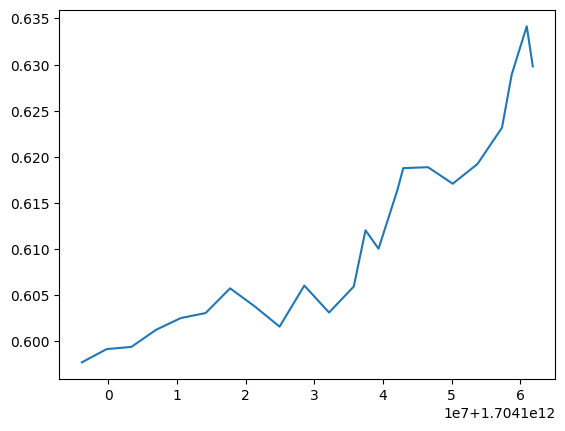

In [4]:
for tp in times_prices:
    print("{0},{1}".format(timestamp_to_human(tp[0]),tp[1]))

plt.plot(*zip(*times_prices))

In [6]:
cd ~/workspace/repo/timeSeries/cntk-lstm-forecast-boilerplate

/config/workspace/repo/timeSeries/cntk-lstm-forecast-boilerplate


In [22]:
pip install -r requirement.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached snet.sdk-3.0.1-py3-none-any.whl (168 kB)
  Using cached snet_cli-2.0.8-py3-none-any.whl (233 kB)
  Using cached snet.snet_cli-2.0.8-py3-none-any.whl (233 kB)
  Using cached ipfsapi-0.4.2.post1-py2.py3-none-any.whl (41 kB)
  Using cached PyYAML-4.2b1-cp310-cp310-linux_x86_64.whl
  Using cached pycoin-0.80-py3-none-any.whl
  Using cached ledgerblue-0.1.27-py3-none-any.whl
  Using cached argcomplete-1.9.4-py2.py3-none-any.whl (36 kB)
  Using cached grpcio_health_checking-1.19.0-py3-none-any.whl
  Using cached grpcio_tools-1.19.0-cp310-cp310-linux_x86_64.whl
  Using cached web3-4.8.3-py3-none-any.whl (124 kB)
  Using cached mnemonic-0.18-py3-none-any.whl
  Using cached pymultihash-0.8.2-py3-none-any.whl (13 kB)
  Using cached base58-1.0.2-py3-none-any.whl (3.3 kB)
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached jsonrpcclient-2.5.2-py3-none-any.whl
  Using cached trezor-0

In [11]:
import os, fnmatch
def findReplaceAll(directory, find, replace, filePattern):
    for path, dirs, files in os.walk(os.path.abspath(directory)):
        for filename in fnmatch.filter(files, filePattern):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace(find, replace)
            with open(filepath, "w") as f:
                f.write(s)

In [18]:
findReplaceAll("/config/.local/lib/python3.10/site-packages/", "import collections", "from collections import", "*.py")

In [21]:
rm -r /config/.local/lib/python3.10/site-packages/*

In [12]:
def findReplace(filename, find, replace):
    # Read in the file
    with open(filename, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace(find, replace)

    # Write the file out again
    with open(filename, 'w') as file:
        file.write(filedata)

In [15]:
findReplace("/config/.local/lib/python3.10/site-packages/eth_account/account.py", "from collections import", "from collections.abc import")

In [31]:
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mapping.py", "from collections import", "from collections.abc import")

In [33]:
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mixins.py", "from collections import", "from collections.abc import")

In [35]:
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/merge.py", "from collections import", "from collections.abc import")

In [19]:
!python3 service.py

Traceback (most recent call last):
  File "/config/workspace/repo/timeSeries/cntk-lstm-forecast-boilerplate/service.py", line 1, in <module>
    from snet.sdk import SnetSDK
  File "/config/.local/lib/python3.10/site-packages/snet/sdk/__init__.py", line 2, in <module>
    from snet.sdk.metadata_provider.ipfs_metadata_provider import IPFSMetadataProvider
  File "/config/.local/lib/python3.10/site-packages/snet/sdk/metadata_provider/ipfs_metadata_provider.py", line 1, in <module>
    from snet.snet_cli.metadata.service import mpe_service_metadata_from_json
  File "/config/.local/lib/python3.10/site-packages/snet/snet_cli/metadata/service.py", line 46, in <module>
    from snet.snet_cli.utils.utils import is_valid_endpoint
  File "/config/.local/lib/python3.10/site-packages/snet/snet_cli/utils/utils.py", line 10, in <module>
    import web3
  File "/config/.local/lib/python3.10/site-packages/web3/__init__.py", line 7, in <module>
    from eth_account import Account  # noqa: E402
  File "/